In [65]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import STL

,Year,Month,Day,Temperature
Date,,,,
1756-01-01,1756,1,1,-8.7
1756-01-02,1756,1,2,-9.2
1756-01-03,1756,1,3,-8.6
1756-01-04,1756,1,4,-7.7
1756-01-05,1756,1,5,-7.2
...,...,...,...,...
2017-12-27,2017,12,27,2.5
2017-12-28,2017,12,28,3.8
2017-12-29,2017,12,29,2.4


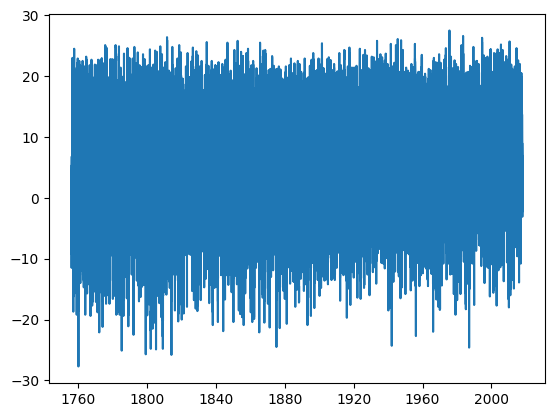

In [21]:
data=pd.read_csv("stockholm_daily_mean_temperature_1756_2017.txt",sep="\s+",header=None,usecols=[0,1,2,5],names=["Year","Month","Day","Temperature"])
data["Date"]=pd.to_datetime(data[["Year","Month","Day"]])
data.set_index("Date",inplace=True)
display(data)
plt.plot(data.index,data["Temperature"])
plt.show()


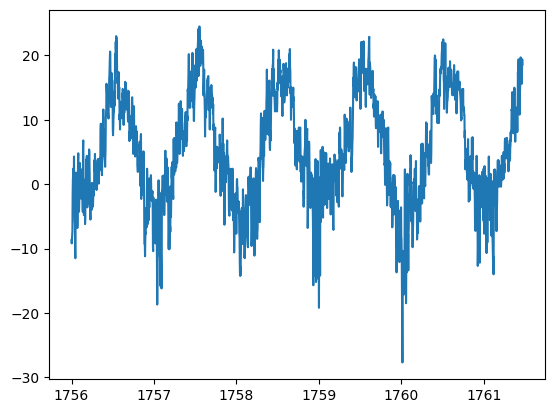

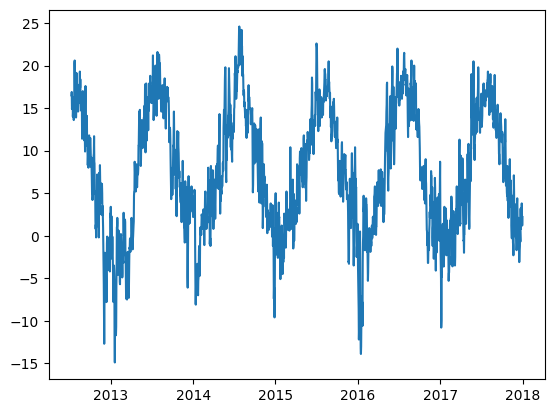

In [56]:
#Zooming in looking for periodicty
first_samples=data.head(2000)
plt.plot(first_samples.index,first_samples["Temperature"])
plt.show()
last_samples=data.tail(2000)
plt.plot(last_samples.index,last_samples["Temperature"])
plt.show()

In [ ]:
#YOU CAN TRY WITH 
#statsmodels.tsa.seasonal.seasonal_decompose
#faster but worse...

In [74]:
seas_decompose=STL(data["Temperature"],period=365,trend=3651).fit()

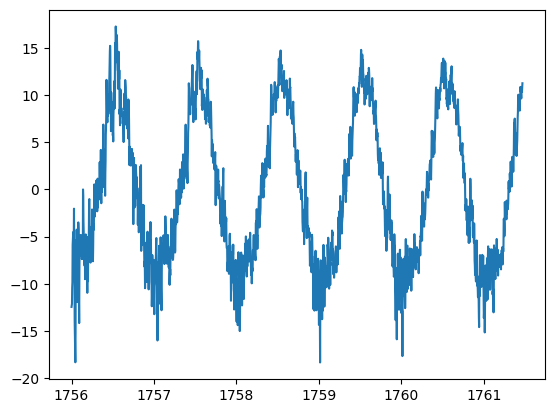

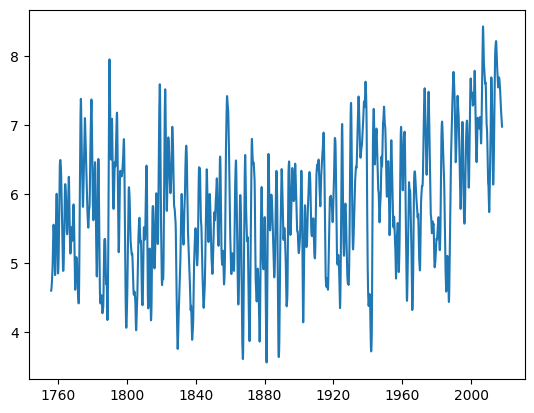

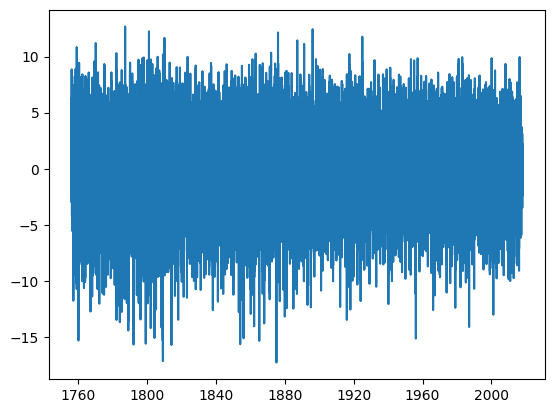

In [70]:
seasonal_component=seas_decompose.seasonal.head(2000)
plt.plot(seasonal_component.index,seasonal_component)
plt.show()
plt.plot(seas_decompose.trend.index,seas_decompose.trend)
plt.show()
plt.plot(seas_decompose.trend.index,seas_decompose.resid)
plt.show()

In [71]:
s=data["Temperature"]-seas_decompose.seasonal

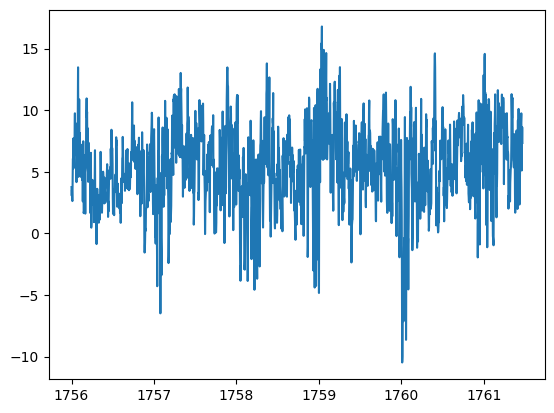

In [72]:
plt.plot(s.head(2000).index,s.head(2000))